In [1]:
import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections

from collections import OrderedDict
import uproot
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/nfshome/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2


# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [91]:
fpath_bkg =OrderedDict()
tree_bkg = OrderedDict()
tree_sig = OrderedDict()
fpath_sig =OrderedDict()
path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/V1p7/MC_Summer16/v11/v5/'
bkg_path = path+"/bkg/wH/normalized/"
# fpath_bkg['QCD'] = bkg_path+"QCD_HT50toInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_1pb_weighted.root"
# fpath_bkg['DYJetsToLL'] = bkg_path+"DYJetsToLL_M-50_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8_1pb_weighted.root"
# fpath_bkg['TTJets_DiLept'] = bkg_path+"TTJets_DiLept_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_1pb_weighted.root"
# fpath_bkg['TTJets_SingleLeptFromTbar'] = bkg_path+"TTJets_SingleLeptFromTbar_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_1pb_weighted.root"
# fpath_bkg['TTJets_SingleLeptFromT'] = bkg_path+"TTJets_SingleLeptFromT_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_1pb_weighted.root"
# fpath_bkg['ZJetsToNuNu'] = bkg_path+"ZJetsToNuNu_Zpt-100toInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_1pb_weighted.root"
fpath_bkg['bbbb10'] = '/mnt/hadoop/store/group/phys_exotica/delayedjets/llpntuple/V1p7/MC_Summer16/v1/sixie/WminusH_HToSSTobbbb_WToLNu_MH-125_MS-40_ctauS-10000_TuneCUETP8M1_13TeV-powheg-pythia8/Run2_LLPNtupler_V1p7_MC_Summer16_RunIISummer16DR80Premix-PUMoriond17_80X_mcRun2_asymptotic_2016_TrancheIV_v6-v1_v1_v1/190819_001050/0000/llp_ntupler_1.root'
fpath_bkg['bbbb1'] = '/mnt/hadoop/store/group/phys_exotica/delayedjets/llpntuple/V1p7/MC_Summer16/v1/sixie/WminusH_HToSSTobbbb_WToLNu_MH-125_MS-40_ctauS-1000_TuneCUETP8M1_13TeV-powheg-pythia8/Run2_LLPNtupler_V1p7_MC_Summer16_RunIISummer16DR80Premix-PUMoriond17_80X_mcRun2_asymptotic_2016_TrancheIV_v6-v1_v1_v1/190819_001101/0000/llp_ntupler_1.root'
NEvents = {}


for k,v in fpath_bkg.items():
    print (k, v)
#     tree[k] = rtnp.root2array(v)
    root_dir = uproot.open(v) 
#     if k[:7] == 'ntuples':
    tree_bkg[k] = root_dir['ntuples']['llp']
    NEvents[k] = root_dir['ntuples']['NEvents'][1]
#     else:
#     tree_bkg[k] = root_dir['MuonSystem']
#     NEvents[k] = root_dir['NEvents'][1]
#     tree[k] = root_dir['ntuples']
#     a = tree_bkg[k]["weight"].array()
#     print ('weights',np.unique(a)*lumi)
#     print(len(a))
#     print(len(a)/ NEvents[k])
#     print(a.shape)


bbbb10 /mnt/hadoop/store/group/phys_exotica/delayedjets/llpntuple/V1p7/MC_Summer16/v1/sixie/WminusH_HToSSTobbbb_WToLNu_MH-125_MS-40_ctauS-10000_TuneCUETP8M1_13TeV-powheg-pythia8/Run2_LLPNtupler_V1p7_MC_Summer16_RunIISummer16DR80Premix-PUMoriond17_80X_mcRun2_asymptotic_2016_TrancheIV_v6-v1_v1_v1/190819_001050/0000/llp_ntupler_1.root
bbbb1 /mnt/hadoop/store/group/phys_exotica/delayedjets/llpntuple/V1p7/MC_Summer16/v1/sixie/WminusH_HToSSTobbbb_WToLNu_MH-125_MS-40_ctauS-1000_TuneCUETP8M1_13TeV-powheg-pythia8/Run2_LLPNtupler_V1p7_MC_Summer16_RunIISummer16DR80Premix-PUMoriond17_80X_mcRun2_asymptotic_2016_TrancheIV_v6-v1_v1_v1/190819_001101/0000/llp_ntupler_1.root


In [93]:
gLLP_decay_vertex = {}
gLLP_beta = {}
ctau = {}
genVertex = {}
gamma = {}
weight = {}
original_ctau = 1000 #in cm
new_ctau = 100 #in cm
for k,T in tree_bkg.items():
    genVertex[k] = np.sqrt(T.array('genVertexX')**2+T.array('genVertexY')**2+T.array('genVertexZ')**2)
    genVertex[k] = np.column_stack((genVertex[k],genVertex[k]))
    gLLP_decay_vertex[k] = np.sqrt(T.array('gLLP_decay_vertex_x')**2+T.array('gLLP_decay_vertex_y')**2+T.array('gLLP_decay_vertex_z')**2)

    gLLP_beta[k] = T.array('gLLP_beta')
    gamma[k] = 1.0/np.sqrt(1-gLLP_beta[k]**2)
    ctau[k] = (gLLP_decay_vertex[k]-genVertex[k])/(gLLP_beta[k]*gamma[k])
    ctau[k] = ctau[k].flatten()
    weight[k] = np.exp(ctau[k]*(1.0/original_ctau - 1.0/new_ctau))

# plot ctau


****************************************
Minimizer is Minuit / Migrad
MinFCN                    =      1.75555
Chi2                      =      3.52284
NDf                       =            3
Edm                       =  2.62806e-09
NCalls                    =           37
Constant                  =      9.22911   +/-   0.0102258   
Slope                     =  -0.00103214   +/-   2.0401e-05  

0.3178118868495984
original ctau is: 9.688573762285957 m

****************************************
Minimizer is Minuit / Migrad
MinFCN                    =     0.144248
Chi2                      =     0.580967
NDf                       =            1
Edm                       =  5.81469e-07
NCalls                    =           32
Constant                  =      9.94451   +/-   0.0116169   
Slope                     =  -0.00202078   +/-   2.35823e-05 

0.44593362666696434
new ctau is: 0.9854425400168965 m


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


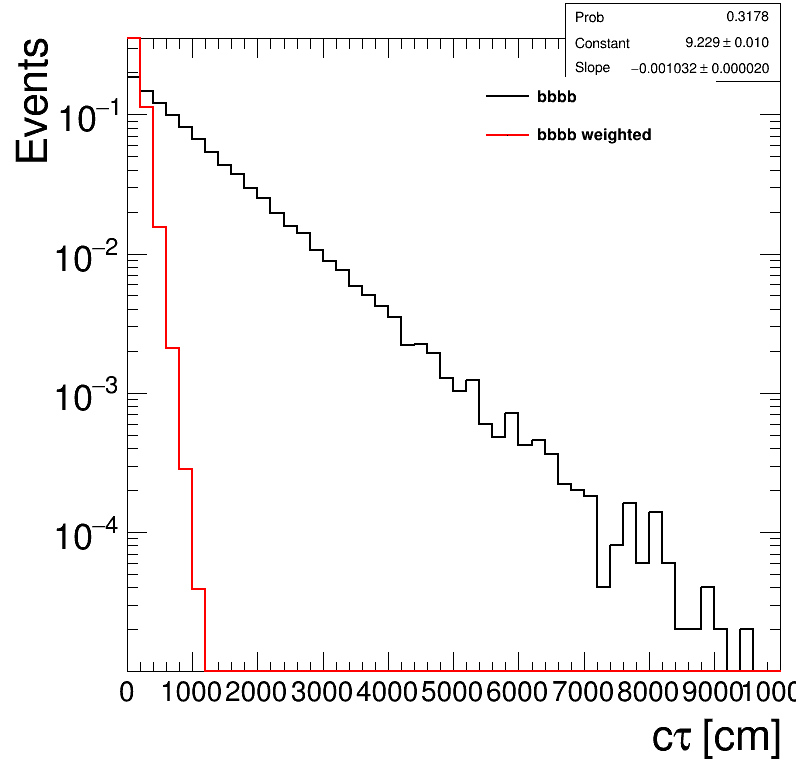

In [90]:

c = rt.TCanvas('c','c', 800, 800)
# h.SetStats(0)
leg = rt.TLegend(0.60,0.80,0.90,0.90)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
h = {}
rt.gStyle.SetOptFit(1011)

k = 'bbbb'
bins = [50,0,10000]
h[k] = create_TH1D( ctau[k], axis_title=['c#tau [cm]', 'Events'], name=k, binning=bins)
h[k+'weight'] = create_TH1D( ctau[k], axis_title=['c#tau [cm]', 'Events'], name=k+'weight', binning=bins,weights = weight[k])
h[k].SetLineColor(std_color_list[0])
h[k+'weight'].SetLineColor(std_color_list[1])

leg.AddEntry(h[k], k)
leg.AddEntry(h[k+'weight'],k+' weighted')
#     h[k].SetMinimum(1)
h[k].GetXaxis().SetLabelSize(0.04)
r = h[k].Fit('expo', 'LRSQ+0', '', 0,1000)
print(r.Get())
print(r.Prob())
h[k].GetFunction("expo").SetLineColor(std_color_list[0])
h[k].GetFunction("expo").SetLineStyle(2)
h[k].GetFunction("expo").SetLineWidth(2)
print('original ctau is: '+str(-1.0/r.Parameter(1)/100)+' m')
h[k].DrawNormalized()
h[k].GetFunction("expo").Delete()

r = h[k+'weight'].Fit('expo', 'LRSQ+0', 'a', 0,1000)
print(r1.Get())
print(r1.Prob())
# h[k+'weight'].GetFunction("expo").SetLineColor(std_color_list[1])
# h[k+'weight'].GetFunction("expo").SetLineStyle(2)
# h[k+'weight'].GetFunction("expo").SetLineWidth(2)
print('new ctau is: '+str(-1.0/r.Parameter(1)/100)+' m')
h[k+'weight'].DrawNormalized('same hist')


leg.Draw('same')
c.SetLogy()


c.Draw()

    
    


# c.Draw()
# print(time.time()-start_t)

# compare other variables

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: bbbb (Potential memory leak).


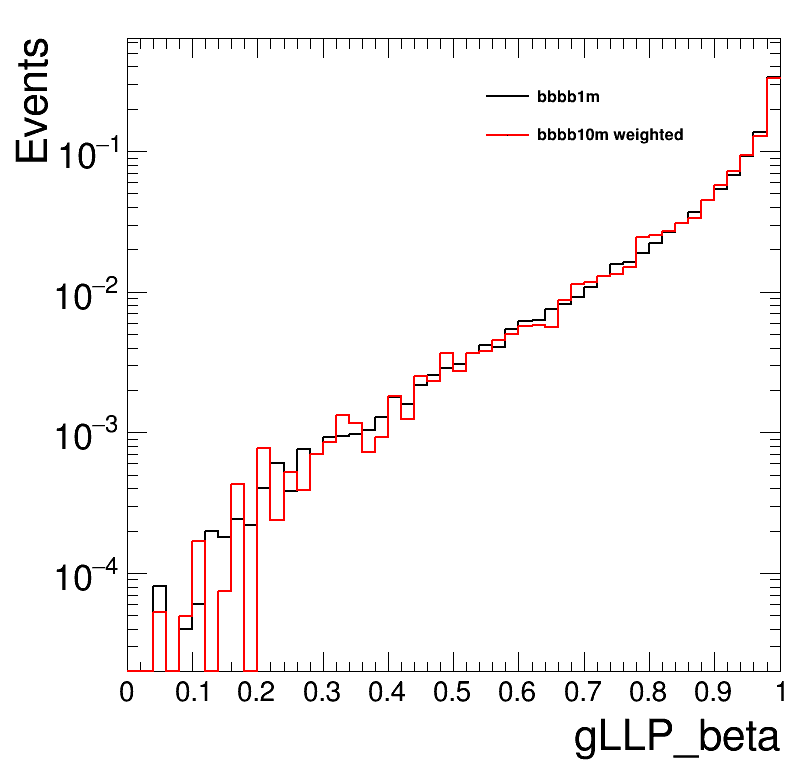

In [100]:

c = rt.TCanvas('c','c', 800, 800)
# h.SetStats(0)
leg = rt.TLegend(0.60,0.80,0.90,0.90)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
h = {}
rt.gStyle.SetOptFit(1011)

bins = [50,0,1]
h['bbbb1m'] = create_TH1D( gLLP_beta['bbbb1'].flatten(), axis_title=['gLLP_beta', 'Events'], name=k, binning=bins)
h['bbbb10m weighted'] = create_TH1D( gLLP_beta['bbbb10'].flatten(), axis_title=['gLLP_beta', 'Events'], name=k+'weight', binning=bins,weights = weight['bbbb10'])
h['bbbb1m'].SetLineColor(std_color_list[0])
h['bbbb10m weighted'].SetLineColor(std_color_list[1])

leg.AddEntry(h['bbbb1m'], 'bbbb1m')
leg.AddEntry(h['bbbb10m weighted'],'bbbb10m weighted')
#     h[k].SetMinimum(1)
h['bbbb1m'].GetXaxis().SetLabelSize(0.04)

h['bbbb1m'].DrawNormalized()
h['bbbb10m weighted'].DrawNormalized('same hist')


leg.Draw('same')
c.SetLogy()


c.Draw()

    
    


# c.Draw()
# print(time.time()-start_t)